## Gerar Labels
convert nomalize data (xcenter, ycenter, w, h) to original Voc (x1, y1, x2, y2) 

In [1]:
import pandas as pd
import os
import numpy as np

from tqdm import tqdm
from glob import glob

In [2]:
'''
carrega o arquivo com o nome e tamanho das imagens do conjunto de teste
'''

# df = pd.read_csv('/home/karem/Artigo_Periodico/1_Dataset/CSV_Files/Folder_1_Covid/test.csv')
df = pd.read_csv('/home/karem/Artigo_Periodico/1_Dataset/CSV_Files/2class_trainCovidNormal/test.csv')

# # coloca a extensão .png no final do nome da imagem
# #df['id'] = df['id'].apply(lambda x: x.replace('_image', '.png'))
# #df[['id']] = df[['id']] + '.png'

# ### Remove os casos negativos
# indexNames = df[df['class_name'] == 'negative'].index
# # Delete these row indexes from dataFrame
# df.drop(indexNames, inplace = True)


# # reinicia o index
# df = df.reset_index(drop=True)


df['class_name'].loc[(df['class_name'] == 'typical')] = 'covid'
df['class_name'].loc[(df['class_name'] == 'indeterminate')] = 'covid'

df['class_name'].loc[(df['class_name'] == 'negative')] = 'normal'

print(len(df))
df.head(5)
#df

564


/home/karem/anaconda3/envs/env_py39/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,id,class_name,width,height,xmin,ymin,xmax,ymax,width_roi,height_roi
0,888109901b29_image,covid,640,640,"[88.0, 332.0]","[158.0, 179.0]","[276.0, 499.0]","[413.0, 506.0]","[188.0, 167.0]","[255.0, 327.0]"
1,35a789322c1d_image,normal,640,640,[0.0],[0.0],[0.0],[0.0],[0.0],[0.0]
2,462a64ef01e3_image,normal,640,640,[0.0],[0.0],[0.0],[0.0],[0.0],[0.0]
3,952d4a77beda_image,covid,640,640,[404.0],[335.0],[517.0],[459.0],[113.0],[124.0]
4,96417c620956_image,covid,640,640,"[101.0, 401.0]","[214.0, 258.0]","[212.0, 513.0]","[473.0, 547.0]","[111.0, 111.0]","[259.0, 289.0]"


#### Create files -> GT

In [3]:
# Convert lista para string
def convert(lst):
    i = ''.join(lst)
    str1 = re.sub(r"[\([{})\]]", "", i)
    return str1

#Cria o dietório caso não exista
def create_folders(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
# se houver a pasta, ela é removida
import shutil
def remove_folders(path):
    if os.path.exists(path):
        shutil.rmtree(path)
        
# Converte string para lista
def Convert_str_to_int(string):
    li = list(string.split(", "))
    return li

import re
def convert_df_lista_int(str1):
    #str1 = df['xmin_ori'][1]
    str1 = re.sub(r"[\([{})\]]", "", str1) # remove os caracteres da string
    #str1 = (str1.replace('.0', '')) # substirui a casa decimal .0 por vazio, tornando a string no formato int
    str1 = Convert_str_to_int(str1) # converte a string em lista
    #str1 = list(map(float, str1)) # converte a lista de string em float
    #str1 = list(map(int, str1)) # converte a lista de float em int
    str1 = [int(float(i)) for i in str1] # convert os valores para inteiro e depois string    
    return str1

In [4]:
# Gera os labels do GT

#path
path_labelsGT = '/home/karem/Artigo_Periodico/Detector/Ensemble/labels/ground_truth/'

remove_folders(path_labelsGT)
create_folders(path_labelsGT)

for i in range(len(df)):
    
    # cria um txt com os nomes das imagens
    # substitui o .png do dataframe para txt
    nome_file = os.path.basename(df.iloc[i,0].replace('_image', '.txt'))
    
    # cria o arquivo txt no modo escrita (w)
    file = open(path_labelsGT + nome_file, "w") 
#     if not (os.path.exists(path_labels_pred + nome_file)): # se o arquivo txt não existir (se a yolo nõa gerou label)
#         print(nome_file)
#         file2 = open(path_labels_pred + nome_file, "w")
#         file2.write('0 0 0 0 0 0') # salva no txt       
    
    lista_int_x1 = convert_df_lista_int(df['xmin'][i])
    lista_int_x2 = convert_df_lista_int(df['xmax'][i])
    lista_int_y1 = convert_df_lista_int(df['ymin'][i])
    lista_int_y2 = convert_df_lista_int(df['ymax'][i])
    
            
    # se a classe for covid, salvará como 0 (0 = covid)
    if df['class_name'][i] == 'covid':
        for j in range(len(lista_int_x1)):
            bb = [lista_int_x1[j], lista_int_y1[j], lista_int_x2[j], lista_int_y2[j]]
            #print(bb)
            result = (convert(str(bb)).replace(',', '')) # transforma a lista em string
            file.write('0 ' + result + '\n') # salva no txt    
    elif df['class_name'][i] == 'normal':
        result = (convert(str(bb)).replace(',', '')) # transforma a lista em string
        file.write('1 ' + result + '\n') # salva no txt    
    file.close() # fecha o txt
#     file2.close()
    

#### Create files -> Pred (Yolo)

In [5]:
# Gera os txt (vazio) que não foram preditos nada para que não haja diferença de quantidade entre o GT e o pred

path_labels_pred = '/home/karem/Artigo_Periodico/Detector/Ensemble/labels/2detectors/'

for i in range(len(df)):
    
    # cria um txt com os nomes das imagens
    # substitui o .png do dataframe para txt
    nome_file = os.path.basename(df.iloc[i,0].replace('_image', '.txt'))
    
    # cria o arquivo txt no modo escrita (w)
    #file = open(path_labelsGT + nome_file, "w") 
    if not (os.path.exists(path_labels_pred + nome_file)): # se o arquivo txt não existir (se a yolo não gerou label)
        print(nome_file)
        file2 = open(path_labels_pred + nome_file, "w")
        file2.write('1 1 0 0 0 0') # salva no txt       
    
        file2.close()
    

## Non max Supression

In [6]:
#Cria o dietório caso não exista
def create_folders(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
        
# se houver a pasta, ela é removida
import shutil
def remove_folders(path):
    if os.path.exists(path):
        shutil.rmtree(path)
        
        
# Convert lista para string
def convert2(lst):    
    return ' '.join(lst)


import re
# Convert lista para string
def convert(lst):
    #i = ''.join(lst)
    i = " ".join(lst.split())
    str1 = re.sub(r"[\([{})\]]", "", i)
    str1 = " ".join(str1.split())
    return str1

In [7]:
path_labels_yolo = '/home/karem/Artigo_Periodico/Detector/Ensemble/labels/2detectors/*.txt'

path_labels_pred = '/home/karem/Artigo_Periodico/Detector/Ensemble/labels/2detectors_pred_final/'

val_thres = 0.5 #NMS
remove_folders(path_labels_pred)
create_folders(path_labels_pred)

In [8]:
# use pytorch and confidence score
#https://learnopencv.com/non-maximum-suppression-theory-and-implementation-in-pytorch/

# use y2 
#https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/

def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,2]
    y1 = boxes[:,3]
    x2 = boxes[:,4]
    y2 = boxes[:,5]
    
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    #idxs = np.argsort(y2)
    
    ## confidence score besides y-coordinate
    conf = boxes[:,1]
    idxs = np.argsort(conf)
    
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
                                               np.where(overlap > overlapThresh)[0])))
    # return only the bounding boxes that were picked using the
    # integer data type
    
    return boxes[pick].astype("int")

In [9]:
for file_path in tqdm(glob(path_labels_yolo)):    
    image_id = file_path.split('/')[-1].split('.')[0] + '_image'
    
    #print(image_id)
    f = open(file_path, 'r')   
    #print(file_path)
    data = np.array(f.read().replace('\n', ' ').strip().split(' ')).astype(np.float32).reshape(-1, 6)
        
    data[:,1] = data[:,1] * 100
    
    
    new_data = non_max_suppression_fast(data, val_thres)
    
    nome_file = os.path.basename(file_path)
    file = open(path_labels_pred + nome_file, "w")  
    for idx in range(len(new_data)):
        result = convert(str(new_data[idx]))
    
        for i in range(0,100):
            result = result.replace(' ' + str(i) + ' ', ' 0.' + str(i) + ' ')

        file.write(result + '\n')
    file.close() 
    

100%|██████████| 564/564 [00:00<00:00, 3255.69it/s]


In [10]:
# ##################################################
# # Usar essa parte no caso de faltar GT (Classificação antecedendo a Detecção)
# ##################################################

# for file_path in tqdm(glob(path_labels_pred)):    
#     image_id = file_path.split('/')[-1].split('.')[0] + '.txt'
    
#     if not(os.path.exists(path_labelsGT + image_id)):
#         file = open(path_labelsGT + image_id, "w")  
#         file.write('0 0 0 0 0\n')
#         file.close()
        
#         print(image_id)   


## mAP

In [11]:
import glob
import json
import os
import shutil
import operator
import sys
import argparse
import math

import numpy as np
import pandas as pd

In [12]:
def log_average_miss_rate(prec, rec, num_images):
    """
        log-average miss rate:
            Calculated by averaging miss rates at 9 evenly spaced FPPI points
            between 10e-2 and 10e0, in log-space.

        output:
                lamr | log-average miss rate
                mr | miss rate
                fppi | false positives per image

        references:
            [1] Dollar, Piotr, et al. "Pedestrian Detection: An Evaluation of the
               State of the Art." Pattern Analysis and Machine Intelligence, IEEE
               Transactions on 34.4 (2012): 743 - 761.
    """

    # if there were no detections of that class
    if prec.size == 0:
        lamr = 0
        mr = 1
        fppi = 0
        return lamr, mr, fppi

    fppi = (1 - prec)
    mr = (1 - rec)

    fppi_tmp = np.insert(fppi, 0, -1.0)
    mr_tmp = np.insert(mr, 0, 1.0)

    # Use 9 evenly spaced reference points in log-space
    ref = np.logspace(-2.0, 0.0, num = 9)
    for i, ref_i in enumerate(ref):
        # np.where() will always find at least 1 index, since min(ref) = 0.01 and min(fppi_tmp) = -1.0
        j = np.where(fppi_tmp <= ref_i)[-1][-1]
        ref[i] = mr_tmp[j]

    # log(0) is undefined, so we use the np.maximum(1e-10, ref)
    lamr = math.exp(np.mean(np.log(np.maximum(1e-10, ref))))

    return lamr, mr, fppi



"""
 throw error and exit
"""
def error(msg):
    print(msg)
    sys.exit(0)
    
    
"""
 check if the number is a float between 0.0 and 1.0
"""
def is_float_between_0_and_1(value):
    try:
        val = float(value)
        if val > 0.0 and val < 1.0:
            return True
        else:
            return False
    except ValueError:
        return False
#####################################################################################################################################
"""
 Calculate the AP given the recall and precision array
    1st) We compute a version of the measured precision/recall curve with
         precision monotonically decreasing
    2nd) We compute the AP as the area under this curve by numerical integration.
"""
def voc_ap(rec, prec):
    """
    --- Official matlab code VOC2012---
    mrec=[0 ; rec ; 1];
    mpre=[0 ; prec ; 0];
    for i=numel(mpre)-1:-1:1
            mpre(i)=max(mpre(i),mpre(i+1));
    end
    i=find(mrec(2:end)~=mrec(1:end-1))+1;
    ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    rec.insert(0, 0.0) # insert 0.0 at begining of list
    rec.append(1.0) # insert 1.0 at end of list
    mrec = rec[:]
    prec.insert(0, 0.0) # insert 0.0 at begining of list
    prec.append(0.0) # insert 0.0 at end of list
    mpre = prec[:]
    """
     This part makes the precision monotonically decreasing
        (goes from the end to the beginning)
        matlab: for i=numel(mpre)-1:-1:1
                    mpre(i)=max(mpre(i),mpre(i+1));
    """
    # matlab indexes start in 1 but python in 0, so I have to do:
    #     range(start=(len(mpre) - 2), end=0, step=-1)
    # also the python function range excludes the end, resulting in:
    #     range(start=(len(mpre) - 2), end=-1, step=-1)
    for i in range(len(mpre)-2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i+1])
    """
     This part creates a list of indexes where the recall changes
        matlab: i=find(mrec(2:end)~=mrec(1:end-1))+1;
    """
    i_list = []
    for i in range(1, len(mrec)):
        if mrec[i] != mrec[i-1]:
            i_list.append(i) # if it was matlab would be i + 1
    """
     The Average Precision (AP) is the area under the curve
        (numerical integration)
        matlab: ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    ap = 0.0
    for i in i_list:
        ap += ((mrec[i]-mrec[i-1])*mpre[i])
    return ap, mrec, mpre


"""
 Convert the lines of a file to a list
"""
def file_lines_to_list(path):
    # open txt file lines to a list
    with open(path) as f:
        content = f.readlines()
    # remove whitespace characters like `\n` at the end of each line
    content = [x.strip() for x in content]
    return content


"""
 Plot - adjust axes
"""
def adjust_axes(r, t, fig, axes):
    # get text width for re-scaling
    bb = t.get_window_extent(renderer=r)
    text_width_inches = bb.width / fig.dpi
    # get axis width in inches
    current_fig_width = fig.get_figwidth()
    new_fig_width = current_fig_width + text_width_inches
    propotion = new_fig_width / current_fig_width
    # get axis limit
    x_lim = axes.get_xlim()
    axes.set_xlim([x_lim[0], x_lim[1]*propotion])

    
    
"""
 Draw plot using Matplotlib
"""
def draw_plot_func(dictionary, n_classes, window_title, plot_title, x_label, output_path, to_show, plot_color, true_p_bar):
    # sort the dictionary by decreasing value, into a list of tuples
    sorted_dic_by_value = sorted(dictionary.items(), key=operator.itemgetter(1))
    # unpacking the list of tuples into two lists
    sorted_keys, sorted_values = zip(*sorted_dic_by_value)
    #   
    
    if true_p_bar != "":
        """
         Special case to draw in:
            - green -> TP: True Positives (object detected and matches ground-truth)
            - red -> FP: False Positives (object detected but does not match ground-truth)
            - pink -> FN: False Negatives (object not detected but present in the ground-truth)
        """
        fp_sorted = []
        tp_sorted = []
        for key in sorted_keys:
            fp_sorted.append(dictionary[key] - true_p_bar[key])
            tp_sorted.append(true_p_bar[key])
        plt.barh(range(n_classes), fp_sorted, align='center', color='crimson', label='False Positive')
        plt.barh(range(n_classes), tp_sorted, align='center', color='forestgreen', label='True Positive', left=fp_sorted)
        # add legend
        plt.legend(loc='lower right')
        """
         Write number on side of bar
        """
        fig = plt.gcf() # gcf - get current figure
        axes = plt.gca()
        r = fig.canvas.get_renderer()
        for i, val in enumerate(sorted_values):
            fp_val = fp_sorted[i]
            tp_val = tp_sorted[i]
            fp_str_val = " " + str(fp_val)
            tp_str_val = fp_str_val + " " + str(tp_val)
            # trick to paint multicolor with offset:
            # first paint everything and then repaint the first number
            t = plt.text(val, i, tp_str_val, color='forestgreen', va='center', fontweight='bold')
            plt.text(val, i, fp_str_val, color='crimson', va='center', fontweight='bold')
            if i == (len(sorted_values)-1): # largest bar
                adjust_axes(r, t, fig, axes)
    else:
        plt.barh(range(n_classes), sorted_values, color=plot_color)
        """
         Write number on side of bar
        """
        fig = plt.gcf() # gcf - get current figure
        axes = plt.gca()
        r = fig.canvas.get_renderer()
        for i, val in enumerate(sorted_values):
            str_val = " " + str(val) # add a space before
            if val < 1.0:
                str_val = " {0:.2f}".format(val)
            t = plt.text(val, i, str_val, color=plot_color, va='center', fontweight='bold')
            # re-set axes to show number inside the figure
            if i == (len(sorted_values)-1): # largest bar
                adjust_axes(r, t, fig, axes)
    # set window title
    fig.canvas.set_window_title(window_title)
    # write classes in y axis
    tick_font_size = 12
    plt.yticks(range(n_classes), sorted_keys, fontsize=tick_font_size)
    """
     Re-scale height accordingly
    """
    init_height = fig.get_figheight()
    # comput the matrix height in points and inches
    dpi = fig.dpi
    height_pt = n_classes * (tick_font_size * 1.4) # 1.4 (some spacing)
    height_in = height_pt / dpi
    # compute the required figure height 
    top_margin = 0.15 # in percentage of the figure height
    bottom_margin = 0.05 # in percentage of the figure height
    figure_height = height_in / (1 - top_margin - bottom_margin)
    # set new height
    if figure_height > init_height:
        fig.set_figheight(figure_height)

    # set plot title
    plt.title(plot_title, fontsize=14)
    # set axis titles
    # plt.xlabel('classes')
    plt.xlabel(x_label, fontsize='large')
    # adjust size of window
    fig.tight_layout()
    # save the plot
    fig.savefig(output_path)
    # show image
    if to_show:
        plt.show()
    # close the plot
    plt.close()

In [21]:
#####################################################################################################################################
#####################################################################################################################################
#####################################################################################################################################
#####################################################################################################################################
#####################################################################################################################################
#####################################################################################################################################
#####################################################################################################################################
#####################################################################################################################################
#####################################################################################################################################

MINOVERLAP = 0.45 # default value (defined in the PASCAL VOC2012 challenge)
# MINOVERLAP = 0.5 # default value (defined in the PASCAL VOC2012 challenge)


parser = argparse.ArgumentParser()
parser.add_argument('-na', '--no-animation', help="no animation is shown.", action="store_true")
parser.add_argument('-np', '--no-plot', help="no plot is shown.", action="store_true")
parser.add_argument('-q', '--quiet', help="minimalistic console output.", action="store_true")
# argparse receiving list of classes to be ignored (e.g., python main.py --ignore person book)
parser.add_argument('-i', '--ignore', nargs='+', type=str, help="ignore a list of classes.")
# argparse receiving list of classes with specific IoU (e.g., python main.py --set-class-iou person 0.7)
parser.add_argument('--set-class-iou', nargs='+', type=str, help="set IoU for a specific class.")
sys.argv = ['-f']
args = parser.parse_args()

#https://sungwookyoo.github.io/tips/ArgParser/
#args = vars(parser.parse_args())



# pal_chave_peso = "ensaio"
# epoca          = 69 
# rede           = 'Mask_rcnn'
# path_input = 'd:/usuarios/diego.cardona/Desktop/Mis programas/mAP-master-YO/input/' 
# path_ouput = path_input + '/output_maP_'+rede+'/'
# GT_PATH = os.path.join( path_input, 'ground-truth')
# DR_PATH = os.path.join( path_input, 'detection-results')

rede = 'ensemble'
#path_input = '/home/karem/Artigo_SPIE_Kaggle/YoloEvaluation/labels/'
#path_ouput = path_input + '/output_maP_' + rede + '/'
#GT_PATH = os.path.join( path_input, 'true_yolo')
#DR_PATH = os.path.join( path_input, 'pred_yolo')

path_input = '/home/karem/Artigo_Periodico/Detector/Ensemble/labels/'
path_ouput = path_input + '/output_maP_' + rede + '/'
GT_PATH = os.path.join(path_input, 'ground_truth')
#GT_PATH = os.path.join(path_input)
DR_PATH = os.path.join(path_input, '2detectors_pred_final')

            
'''
    0,0 ------> x (width)
     |
     |  (Left,Top)
     |      *_________
     |      |         |
            |         |
     y      |_________|
  (height)            *
                (Right,Bottom)
'''

# if there are no classes to ignore then replace None by empty list
if args.ignore is None:
    args.ignore = []

specific_iou_flagged = False
if args.set_class_iou is not None:
    specific_iou_flagged = True

# make sure that the cwd() is the location of the python script (so that every path makes sense)
#os.chdir(os.path.dirname(os.path.abspath(__file__)))


# GT_PATH = os.path.join( path_input, 'true_mask_rcnn')
# DR_PATH = os.path.join( path_input, 'pred_mask_rcnn')

# if there are no images then no animation can be shown
args.no_animation = True


# try to import Matplotlib if the user didn't choose the option --no-plot
draw_plot = False
if not args.no_plot:
    try:
        import matplotlib.pyplot as plt
        draw_plot = True
    except ImportError:
        print("\"matplotlib\" not found, please install it to get the resulting plots.")
        args.no_plot = True


In [22]:
"""
 Create a ".temp_files/" and "output/" directory
"""

#draw_plot = False

TEMP_FILES_PATH = ".temp_files"
if not os.path.exists(TEMP_FILES_PATH): # if it doesn't exist already
    os.makedirs(TEMP_FILES_PATH)
    

if os.path.exists(path_ouput): # if it exist already
    # reset the output directory
    shutil.rmtree(path_ouput)

os.makedirs(path_ouput)
if draw_plot:
    os.makedirs(os.path.join(path_ouput, "classes"))


    
    
    
"""
 ground-truth
     Load each of the ground-truth files into a temporary ".json" file.
     Create a list of all the class names present in the ground-truth (gt_classes).
"""
# get a list with the ground-truth files
ground_truth_files_list = glob.glob(GT_PATH + '/*.txt')
if len(ground_truth_files_list) == 0:
    error("Error: No ground-truth files found!")
ground_truth_files_list.sort()
# dictionary with counter per class
gt_counter_per_class = {}
counter_images_per_class = {}

gt_files = []
for txt_file in ground_truth_files_list:
    #print(txt_file)
    file_id = txt_file.split(".txt", 1)[0]
    file_id = os.path.basename(os.path.normpath(file_id))
    # check if there is a correspondent detection-results file
    temp_path = os.path.join(DR_PATH, (file_id + ".txt"))
    if not os.path.exists(temp_path):
        error_msg = "Error. File not found: {}\n".format(temp_path)
        error_msg += "(You can avoid this error message by running extra/intersect-gt-and-dr.py)"
        error(error_msg)
    lines_list = file_lines_to_list(txt_file)
    # create ground-truth dictionary
    bounding_boxes = []
    is_difficult = False
    already_seen_classes = []
    for line in lines_list:
        try:
            if "difficult" in line:
                    class_name, left, top, right, bottom, _difficult = line.split()
                    is_difficult = True
            else:
                    class_name, left, top, right, bottom = line.split()
        except ValueError:
            error_msg = "Error: File " + txt_file + " in the wrong format.\n"
            error_msg += " Expected: <class_name> <left> <top> <right> <bottom> ['difficult']\n"
            error_msg += " Received: " + line
            error_msg += "\n\nIf you have a <class_name> with spaces between words you should remove them\n"
            error_msg += "by running the script \"remove_space.py\" or \"rename_class.py\" in the \"extra/\" folder."
            error(error_msg)
        # check if class is in the ignore list, if yes skip
        if class_name in args.ignore:
            continue
        bbox = left + " " + top + " " + right + " " +bottom
        if is_difficult:
            bounding_boxes.append({"class_name":class_name, "bbox":bbox, "used":False, "difficult":True})
            is_difficult = False
        else:
            bounding_boxes.append({"class_name":class_name, "bbox":bbox, "used":False})
            # count that object
            if class_name in gt_counter_per_class:
                gt_counter_per_class[class_name] += 1
            else:
                # if class didn't exist yet
                gt_counter_per_class[class_name] = 1

            if class_name not in already_seen_classes:
                if class_name in counter_images_per_class:
                    counter_images_per_class[class_name] += 1
                else:
                    # if class didn't exist yet
                    counter_images_per_class[class_name] = 1
                already_seen_classes.append(class_name)


    # dump bounding_boxes into a ".json" file
    new_temp_file = TEMP_FILES_PATH + "/" + file_id + "_ground_truth.json"
    gt_files.append(new_temp_file)
    with open(new_temp_file, 'w') as outfile:
        json.dump(bounding_boxes, outfile)

gt_classes = list(gt_counter_per_class.keys())
# let's sort the classes alphabetically
gt_classes = sorted(gt_classes)
n_classes = len(gt_classes)
#print(gt_classes)
#print(gt_counter_per_class)





"""
 Check format of the flag --set-class-iou (if used)
    e.g. check if class exists
"""
if specific_iou_flagged:
    n_args = len(args.set_class_iou)
    error_msg = \
        '\n --set-class-iou [class_1] [IoU_1] [class_2] [IoU_2] [...]'
    if n_args % 2 != 0:
        error('Error, missing arguments. Flag usage:' + error_msg)
    # [class_1] [IoU_1] [class_2] [IoU_2]
    # specific_iou_classes = ['class_1', 'class_2']
    specific_iou_classes = args.set_class_iou[::2] # even
    # iou_list = ['IoU_1', 'IoU_2']
    iou_list = args.set_class_iou[1::2] # odd
    if len(specific_iou_classes) != len(iou_list):
        error('Error, missing arguments. Flag usage:' + error_msg)
    for tmp_class in specific_iou_classes:
        if tmp_class not in gt_classes:
                    error('Error, unknown class \"' + tmp_class + '\". Flag usage:' + error_msg)
    for num in iou_list:
        if not is_float_between_0_and_1(num):
            error('Error, IoU must be between 0.0 and 1.0. Flag usage:' + error_msg)

            
            
"""
 detection-results
     Load each of the detection-results files into a temporary ".json" file.
"""
# get a list with the detection-results files
dr_files_list = glob.glob(DR_PATH + '/*.txt')
dr_files_list.sort()

for class_index, class_name in enumerate(gt_classes):
    bounding_boxes = []
    for txt_file in dr_files_list:
        #print(txt_file)
        # the first time it checks if all the corresponding ground-truth files exist
        file_id = txt_file.split(".txt",1)[0]
        file_id = os.path.basename(os.path.normpath(file_id))
        temp_path = os.path.join(GT_PATH, (file_id + ".txt"))
        if class_index == 0:
            if not os.path.exists(temp_path):
                error_msg = "Error. File not found: {}\n".format(temp_path)
                error_msg += "(You can avoid this error message by running extra/intersect-gt-and-dr.py)"
                error(error_msg)
        lines = file_lines_to_list(txt_file)
        for line in lines:
            try:
                tmp_class_name, confidence, left, top, right, bottom = line.split()
            except ValueError:
                error_msg = "Error: File " + txt_file + " in the wrong format.\n"
                error_msg += " Expected: <class_name> <confidence> <left> <top> <right> <bottom>\n"
                error_msg += " Received: " + line
                error(error_msg)
            if tmp_class_name == class_name:
                #print("match")
                bbox = left + " " + top + " " + right + " " +bottom
                bounding_boxes.append({"confidence":confidence, "file_id":file_id, "bbox":bbox})
                #print(bounding_boxes)
    # sort detection-results by decreasing confidence
    bounding_boxes.sort(key=lambda x:float(x['confidence']), reverse=True)
    with open(TEMP_FILES_PATH + "/" + class_name + "_dr.json", 'w') as outfile:
        json.dump(bounding_boxes, outfile)


35.53% = 0 AP 
0.00% = 1 AP 
mAP = 17.77%


/tmp/ipykernel_47034/18172192.py:128: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title('AP ' + class_name)


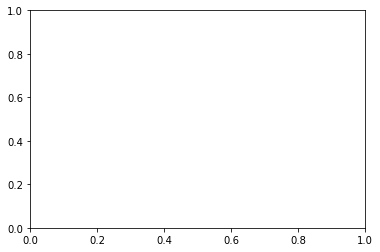

In [23]:
"""
 Calculate the AP for each class
"""
sum_AP = 0.0
ap_dictionary = {}
lamr_dictionary = {}
# open file to store the output
with open(path_ouput + "/output.txt", 'w') as output_file:
    output_file.write("# AP and precision/recall per class\n")
    count_true_positives = {}
    for class_index, class_name in enumerate(gt_classes):
        count_true_positives[class_name] = 0
        """
         Load detection-results of that class
        """
        dr_file = TEMP_FILES_PATH + "/" + class_name + "_dr.json"
        dr_data = json.load(open(dr_file))

        """
         Assign detection-results to ground-truth objects
        """
        nd = len(dr_data)
        tp = [0] * nd # creates an array of zeros of size nd
        fp = [0] * nd
        for idx, detection in enumerate(dr_data):
            file_id = detection["file_id"]
            
            # assign detection-results to ground truth object if any
            # open ground-truth with that file_id
            gt_file = TEMP_FILES_PATH + "/" + file_id + "_ground_truth.json"
            ground_truth_data = json.load(open(gt_file))
            ovmax = -1
            gt_match = -1
            # load detected object bounding-box
            bb = [ float(x) for x in detection["bbox"].split() ]
            for obj in ground_truth_data:
                # look for a class_name match
                if obj["class_name"] == class_name:
                    bbgt = [ float(x) for x in obj["bbox"].split() ]
                    bi = [max(bb[0],bbgt[0]), max(bb[1],bbgt[1]), min(bb[2],bbgt[2]), min(bb[3],bbgt[3])]
                    iw = bi[2] - bi[0] + 1
                    ih = bi[3] - bi[1] + 1
                    if iw > 0 and ih > 0:
                        # compute overlap (IoU) = area of intersection / area of union
                        ua = (bb[2] - bb[0] + 1) * (bb[3] - bb[1] + 1) + (bbgt[2] - bbgt[0]
                                        + 1) * (bbgt[3] - bbgt[1] + 1) - iw * ih
                        ov = iw * ih / ua
                        if ov > ovmax:
                            ovmax = ov
                            gt_match = obj

            # assign detection as true positive/don't care/false positive
            # set minimum overlap
            min_overlap = MINOVERLAP
            if specific_iou_flagged:
                if class_name in specific_iou_classes:
                    index = specific_iou_classes.index(class_name)
                    min_overlap = float(iou_list[index])
            if ovmax >= min_overlap:
                if "difficult" not in gt_match:
                        if not bool(gt_match["used"]):
                            # true positive
                            tp[idx] = 1
                            gt_match["used"] = True
                            count_true_positives[class_name] += 1
                            # update the ".json" file
                            with open(gt_file, 'w') as f:
                                    f.write(json.dumps(ground_truth_data))
                        else:
                            # false positive (multiple detection)
                            fp[idx] = 1

            else:
                # false positive
                fp[idx] = 1
                if ovmax > 0:
                    status = "INSUFFICIENT OVERLAP"

        #print(tp)
        # compute precision/recall
        cumsum = 0
        for idx, val in enumerate(fp):
            fp[idx] += cumsum
            cumsum += val
        cumsum = 0
        for idx, val in enumerate(tp):
            tp[idx] += cumsum
            cumsum += val
        #print(tp)
        rec = tp[:]
        for idx, val in enumerate(tp):
            rec[idx] = float(tp[idx]) / gt_counter_per_class[class_name]
        #print(rec)
        prec = tp[:]
        for idx, val in enumerate(tp):
            prec[idx] = float(tp[idx]) / (fp[idx] + tp[idx])
        #print(prec)

        ap, mrec, mprec = voc_ap(rec[:], prec[:])
        sum_AP += ap
        text = "{0:.2f}%".format(ap*100) + " = " + class_name + " AP " #class_name + " AP = {0:.2f}%".format(ap*100)
        """
         Write to output.txt
        """
        rounded_prec = [ '%.2f' % elem for elem in prec ]
        rounded_rec = [ '%.2f' % elem for elem in rec ]
        output_file.write(text + "\n Precision: " + str(rounded_prec) + "\n Recall :" + str(rounded_rec) + "\n\n")
        if not args.quiet:
            print(text)
        ap_dictionary[class_name] = ap

        n_images = counter_images_per_class[class_name]
        lamr, mr, fppi = log_average_miss_rate(np.array(prec), np.array(rec), n_images)
        lamr_dictionary[class_name] = lamr

        """
         Draw plot
        """
        if draw_plot:
            plt.plot(rec, prec, '-o')
            # add a new penultimate point to the list (mrec[-2], 0.0)
            # since the last line segment (and respective area) do not affect the AP value
            area_under_curve_x = mrec[:-1] + [mrec[-2]] + [mrec[-1]]
            area_under_curve_y = mprec[:-1] + [0.0] + [mprec[-1]]
            plt.fill_between(area_under_curve_x, 0, area_under_curve_y, alpha=0.2, edgecolor='r')
            # set window title
            fig = plt.gcf() # gcf - get current figure
            fig.canvas.set_window_title('AP ' + class_name)
            # set plot title
            plt.title('class: ' + text)
            #plt.suptitle('This is a somewhat long figure title', fontsize=16)
            # set axis titles
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            # optional - set axes
            axes = plt.gca() # gca - get current axes
            axes.set_xlim([0.0,1.0])
            axes.set_ylim([0.0,1.05]) # .05 to give some extra space
            # Alternative option -> wait for button to be pressed
            #while not plt.waitforbuttonpress(): pass # wait for key display
            # Alternative option -> normal display
            #plt.show()
            # save the plot
            fig.savefig(path_ouput + "/classes/" + class_name + ".png")
            plt.cla() # clear axes for next plot


    output_file.write("\n# mAP of all classes\n")
    mAP = sum_AP / n_classes
    text = "mAP = {0:.2f}%".format(mAP*100)
    output_file.write(text + "\n")
    print(text)

# remove the temp_files directory
shutil.rmtree(TEMP_FILES_PATH)


/tmp/ipykernel_47034/2327614893.py:209: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title(window_title)


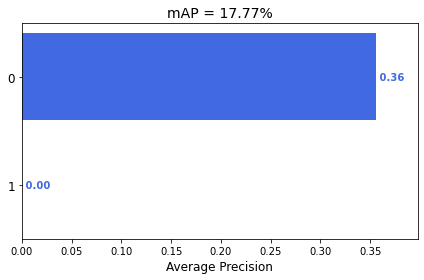

In [24]:
"""
 Count total of detection-results
"""
# iterate through all the files
det_counter_per_class = {}
for txt_file in dr_files_list:
    # get lines to list
    lines_list = file_lines_to_list(txt_file)
    for line in lines_list:
        class_name = line.split()[0]
        # check if class is in the ignore list, if yes skip
        if class_name in args.ignore:
            continue
        # count that object
        if class_name in det_counter_per_class:
            det_counter_per_class[class_name] += 1
        else:
            # if class didn't exist yet
            det_counter_per_class[class_name] = 1
#print(det_counter_per_class)
dr_classes = list(det_counter_per_class.keys())




"""
 Plot the total number of occurences of each class in the ground-truth
"""
if draw_plot:
    window_title = "ground-truth-info"
    plot_title = "ground-truth\n"
    plot_title += "(" + str(len(ground_truth_files_list)) + " files and " + str(n_classes) + " classes)"
    x_label = "Number of objects per class"
    output_path = path_ouput + "/ground-truth-info.png"
    to_show = False
    plot_color = 'forestgreen'
    draw_plot_func(
        gt_counter_per_class,
        n_classes,
        window_title,
        plot_title,
        x_label,
        output_path,
        to_show,
        plot_color,
        '',
        )

    
    
"""
 Write number of ground-truth objects per class to results.txt
"""
with open(path_ouput + "/output.txt", 'a') as output_file:
    output_file.write("\n# Number of ground-truth objects per class\n")
    for class_name in sorted(gt_counter_per_class):
        output_file.write(class_name + ": " + str(gt_counter_per_class[class_name]) + "\n")
        
        
        
"""
 Finish counting true positives
"""
for class_name in dr_classes:
    # if class exists in detection-result but not in ground-truth then there are no true positives in that class
    if class_name not in gt_classes:
        count_true_positives[class_name] = 0

        
        
        
        
"""
 Plot the total number of occurences of each class in the "detection-results" folder
"""
if draw_plot:
    window_title = "detection-results-info"
    # Plot title
    plot_title = "detection-results\n"
    plot_title += "(" + str(len(dr_files_list)) + " files and "
    count_non_zero_values_in_dictionary = sum(int(x) > 0 for x in list(det_counter_per_class.values()))
    plot_title += str(count_non_zero_values_in_dictionary) + " detected classes)"
    # end Plot title
    x_label = "Number of objects per class"
    output_path = path_ouput + "/detection-results-info.png"
    to_show = False
    plot_color = 'forestgreen'
    true_p_bar = count_true_positives
    draw_plot_func(
            det_counter_per_class,
            len(det_counter_per_class),
            window_title,
            plot_title,
            x_label,
            output_path,
            to_show,
            plot_color,
            true_p_bar
        )

    
    
    
"""
 Write number of detected objects per class to output.txt
"""
with open(path_ouput + "/output.txt", 'a') as output_file:
    output_file.write("\n# Number of detected objects per class\n")
    for class_name in sorted(dr_classes):
        n_det = det_counter_per_class[class_name]
        text = class_name + ": " + str(n_det)
        text += " (tp:" + str(count_true_positives[class_name]) + ""
        text += ", fp:" + str(n_det - count_true_positives[class_name]) + ")\n"
        output_file.write(text)

        
"""
 Draw mAP plot (Show AP's of all classes in decreasing order)
"""
if draw_plot:
    window_title = "mAP"
    plot_title = "mAP = {0:.2f}%".format(mAP*100)
    x_label = "Average Precision"
    output_path = path_ouput + "/mAP.png"
    to_show = True
    plot_color = 'royalblue'
    draw_plot_func(
            ap_dictionary,
            n_classes,
            window_title,
            plot_title,
            x_label,
            output_path,
            to_show,
            plot_color,
        ""
        )
        